## This Notebook wil be used to create a model that can predict wether or not the sound barrier (given certain parameters) will or will not be exceeded at a certain location.

### Importing the necessary libraries

In [8]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import pickle

### Importing the Data

In [26]:
df= pd.read_csv('data/model_input.csv',delimiter=';')
df.drop(['location'],axis=1,inplace=True)
# remove instances where lceq_avg is 0 by the average of the column
df['lceq_avg'].replace(0,df['lceq_avg'].mean(),inplace=True)
df['lcpeak_avg'].replace(0,df['lcpeak_avg'].mean(),inplace=True)

### Regression Case

In a first time what we want to do is to predict the exact sound level based on the parameters given to our model. We don't expect exceptional results here, but we want to see if we can get a model that can predict the sound level with a decent accuracy. We also want to see which models are best at capturing the complexity of the data.

#### Time Series Analysis using the Prophet model (Facebook)

Link to the online notebook: https://app.datacamp.com/workspace/w/0b7e6a72-68e0-492b-9382-706bc85378a4/edit (because Prophet does not work on apple silicon)

We can see that the Prophet model is really good at capturing the average sound levels over the year, but what we are looking for is to capture those sound level peaks. Note that the prophet model is also only trained using the timestamp, so no weather or telraam data is used. 

### Regression using Gradient Boosting (XGBoost) and Random Forest

In [29]:
# split data into train and test
X = df.drop(columns=['lcpeak_avg','lceq_avg'],axis=1)
y = df['lcpeak_avg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Gradient Boosting

Finding the best hyperparameters using RandomSearchCV

In [36]:
# use RandomizedSearchCV to find the best parameters for the xgboost model
# define the model
model = xgb.XGBRegressor()
# define the parameters to search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
learning_rate = [0.01,0.05,0.1,0.2,0.3]
subsample = [0.5,0.6,0.7,0.8,0.9,1]
colsample_bytree = [0.5,0.6,0.7,0.8,0.9,1]
gamma = [0,1,5]
reg_alpha = [0,1,5]
reg_lambda = [0,1,5]
# create the grid
grid = dict(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,subsample=subsample,colsample_bytree=colsample_bytree,gamma=gamma,reg_alpha=reg_alpha,reg_lambda=reg_lambda)
# define the search
search = RandomizedSearchCV(model, grid, scoring= 'neg_mean_squared_error', n_jobs=-1, cv=5, verbose=3)
# perform the search
results = search.fit(df.drop(['lcpeak_avg','lceq_avg'],axis=1), df['lcpeak_avg'])
# summarize best
print('Config: %s' % results.best_params_)
# Config: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=-7.301 total time=   4.6s
[CV 2/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=-5.909 total time=   4.8s
[CV 4/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=-7.306 total time=   4.8s
[CV 5/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=-10.235 total time=   4.8s
[CV 1/5] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=200, reg_alpha=1, reg_lambda=5, subsample=0.8;, score=-10.788 total time=   5.0s
[CV 2/5] END colsample_bytree=1, gamma=5, learning_rate=0.1, max_depth=10, n_estimators=400,

The best parameters are: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}

In [45]:
# create a XGBoost model with the best parameters
model = xgb.XGBRegressor(subsample=1,reg_lambda=1,reg_alpha=5,n_estimators=200,max_depth=9,learning_rate=0.05,gamma=0,colsample_bytree=0.7)
# fit the model
model.fit(X_train,y_train)
# make predictions
y_pred = model.predict(X_test)
# evaluate predictions
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('R2: %.3f' % r2_score(y_test, y_pred))
# evaluation on training set
y_pred_train = model.predict(X_train)
print('MSE training: %.3f' % mean_squared_error(y_train, y_pred_train))
print('R2 training: %.3f' % r2_score(y_train, y_pred_train))

MSE: 3.340
R2: 0.894
MSE training: 2.404
R2 training: 0.925


In [46]:
# save the model
pickle.dump(model, open('models/xgb_regression.pkl', 'wb'))

This is a good model and it is not overfitting

Evaluation of the model

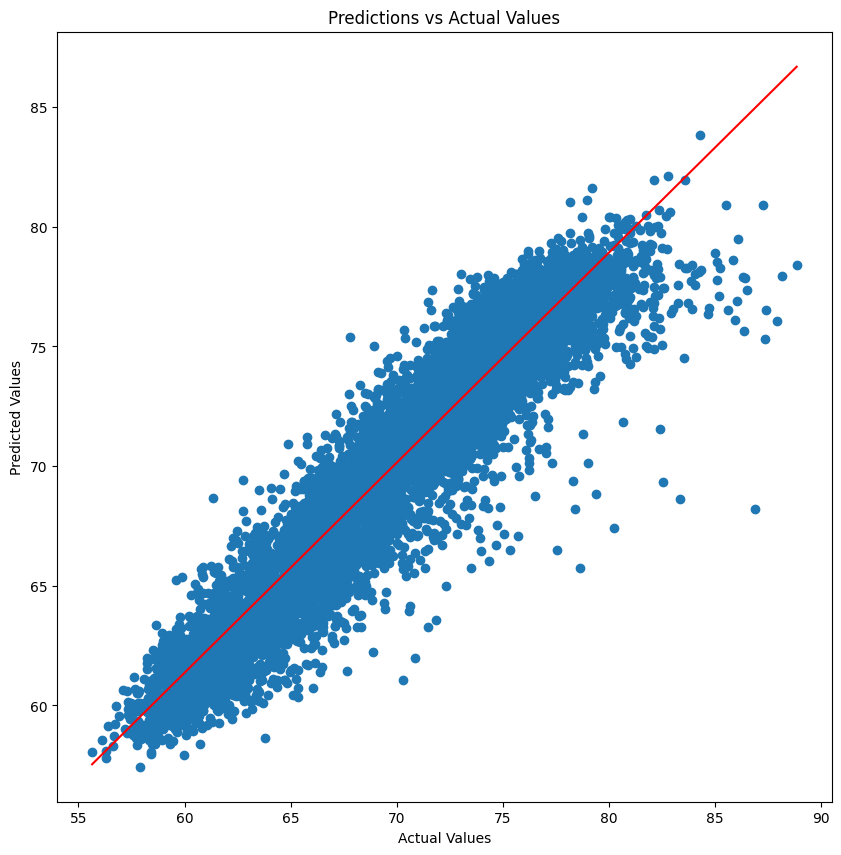

In [47]:
# plot the predictions vs the actual values
plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred)
# add the line of best fit in red
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.show()

However, we can see that the model is having trouble with the regression when the sound level exceeds +- 80 dB.

#### Random Forest

In [40]:
# use RandomizedSearchCV to find the best parameters for the random forest model
# define the model
model = RandomForestRegressor()
# define the parameters to search
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# create the grid
grid = dict(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,bootstrap=bootstrap)
# define the search
search = RandomizedSearchCV(model, grid, scoring= 'neg_mean_squared_error', n_jobs=-1, cv=5, verbose=3)
# perform the search
results = search.fit(df.drop(['lcpeak_avg','lceq_avg'],axis=1), df['lcpeak_avg'])
# summarize best
print('Config: %s' % results.best_params_)
# Config: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'bootstrap': True}

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END bootstrap=False, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-8.023 total time=  29.5s
[CV 1/5] END bootstrap=False, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-10.493 total time=  30.1s
[CV 2/5] END bootstrap=True, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-7.781 total time=  29.5s
[CV 3/5] END bootstrap=False, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-9.367 total time=  31.2s
[CV 1/5] END bootstrap=True, max_depth=3, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-10.438 total time=  30.5s
[CV 4/5] END bootstrap=False, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-9.151 total time=  32.1s
[CV 5/5] END bootstrap=False, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-9.029 total time=  

The best parameters are: {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 8, 'bootstrap': True}

In [42]:
# create random forest model with the best parameters
model = RandomForestRegressor(n_estimators=1200,min_samples_split=10,min_samples_leaf=2,max_depth=8,bootstrap=True)
# fit the model
model.fit(X_train,y_train)
# make predictions
y_pred = model.predict(X_test)
# evaluate predictions
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('R2: %.3f' % r2_score(y_test, y_pred))
# evaluation on training set
y_pred_train = model.predict(X_train)
print('MSE training: %.3f' % mean_squared_error(y_train, y_pred_train))
print('R2 training: %.3f' % r2_score(y_train, y_pred_train))

MSE: 5.545
R2: 0.823
MSE training: 5.328
R2 training: 0.834


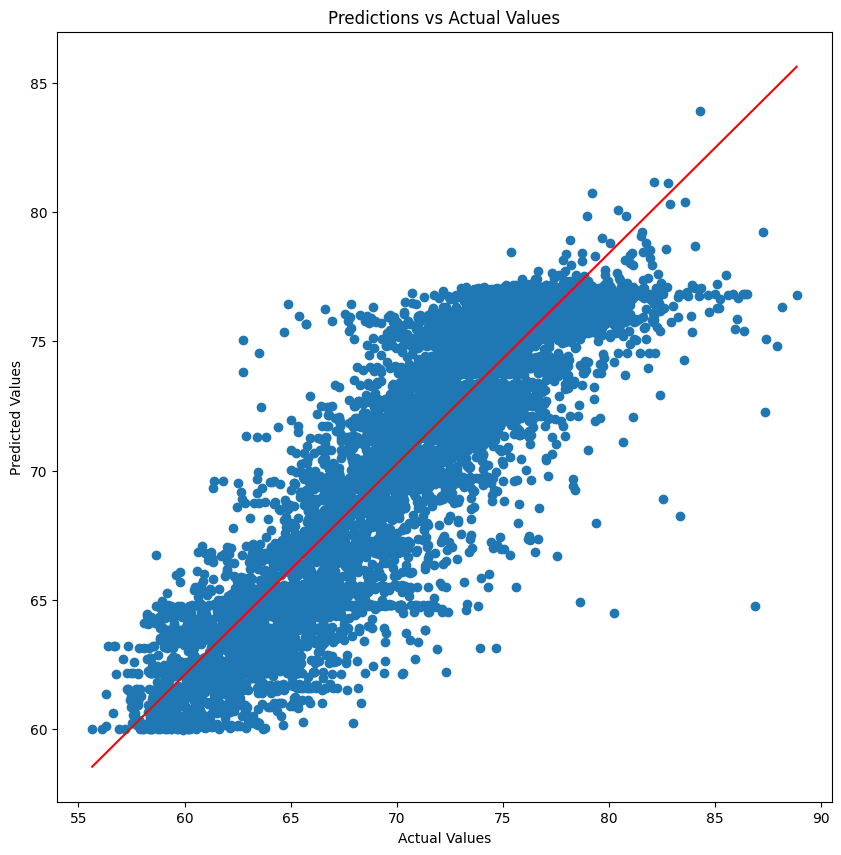

In [43]:
# plot the predictions vs the actual values
plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred)
# add the line of best fit in red
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.show()

In this case the XGB model performs better.

In [44]:
# save the model
pickle.dump(model, open('models/rf_regression.pkl', 'wb'))

### Classification Using Gradient Boosting (XGBoost) and Random Forest

If we now want to build a model that is able to predict wether or not the sound barrier will be exceeded, we need to transform our data into a classification problem. We are choosing the sound level of 75 dB as a threshold for the lcpeak_avg value.

In [41]:
# proportion of the df where lcpeak_avg > 75 ?
df[df['lcpeak_avg'] > 75].count()[0]/df.count()[0]

0.3028538812785388